# Logistic Regression - Multi-Layer Case(For Mnist)

# Library

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [4]:
# hypter parameter setting
learning_rate = 1e-1
epochs = 25
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.ReLU()
h = 200
display_step = 5

# Load data and pre-process data 

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


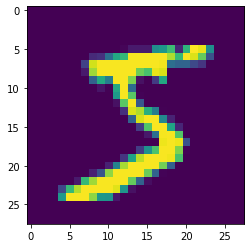

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([2, 8, 9, 7, 7, 3, 2, 9, 5, 9, 6, 5, 4, 3, 8, 4, 7, 6, 0, 8, 1, 6, 3, 1,
        2, 0, 1, 3, 0, 9, 3, 5])


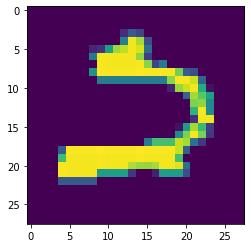

In [5]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Multi Layer Logistic Regression

## Train and result (with mini-batch stochastic gradient descent)

In [12]:
model = nn.Sequential(
    nn.Linear(28*28,h),
    act,
    nn.Linear(h,100),
    act,
    nn.Linear(100,10))

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

Epoch: 1 \Loss: tensor(0.0689, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward>)


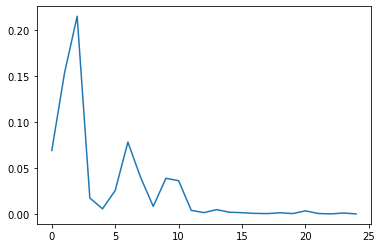

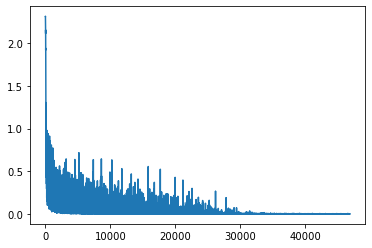

In [13]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

In [14]:
# test
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9831., device='cuda:0')
accuracy tensor(0.9831, device='cuda:0')


In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 968,    0,    1,    1,    2,    1,    3,    1,    2,    1],
       [   0, 1128,    1,    1,    0,    0,    2,    1,    2,    0],
       [   3,    1, 1011,    3,    3,    0,    2,    3,    6,    0],
       [   1,    0,    4,  994,    0,    2,    0,    4,    1,    4],
       [   1,    0,    2,    0,  964,    0,    5,    2,    0,    8],
       [   2,    0,    0,    8,    1,  871,    2,    1,    3,    4],
       [   2,    1,    2,    1,    5,    3,  944,    0,    0,    0],
       [   1,    3,    6,    4,    0,    0,    0, 1005,    4,    5],
       [   4,    0,    1,    2,    3,    1,    2,    2,  955,    4],
       [   1,    2,    0,    2,    6,    2,    1,    1,    3,  991]])

## Advanced: Weight initialization

In [18]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),h),
        act,
        nn.Linear(h,10),
        )

model.apply(init_weights)
model = model.to(device)
model.train()


# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 1 \Loss: tensor(0.1683, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0311, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward>)


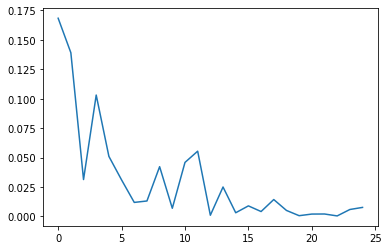

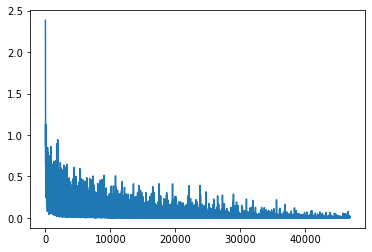

In [19]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

In [20]:
# test
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9808., device='cuda:0')
accuracy tensor(0.9808, device='cuda:0')


In [21]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 972,    0,    1,    1,    1,    0,    1,    1,    2,    1],
       [   0, 1125,    2,    1,    0,    1,    2,    1,    3,    0],
       [   3,    2, 1008,    2,    3,    0,    2,    6,    6,    0],
       [   0,    0,    5,  990,    0,    5,    0,    3,    1,    6],
       [   2,    0,    3,    1,  962,    0,    3,    2,    0,    9],
       [   2,    0,    0,    5,    1,  878,    3,    0,    2,    1],
       [   5,    3,    2,    1,    3,    4,  938,    1,    1,    0],
       [   0,    3,    9,    1,    0,    0,    0, 1007,    3,    5],
       [   5,    0,    3,    4,    2,    2,    1,    3,  952,    2],
       [   2,    2,    1,    3,    9,    4,    2,    7,    3,  976]])

# Reguralization (Dropout, Normalization)
> ## 1. Library

> ## 2. MLP naive setting & Pre-process data

> ## 3. MLP batch norm
>> ### 3.1 with test phase
>> ### 3.2 with train, test phase

> ## 4. Dropout

> ## 5. Batch norm & Dropout

# Library

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [25]:
# hypter parameter setting
learning_rate = 1e-1
epochs = 30
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 5

# Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


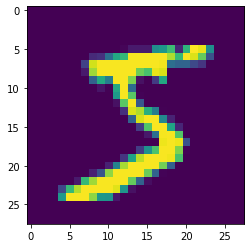

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([7, 2, 5, 8, 1, 4, 5, 6, 5, 1, 7, 2, 6, 9, 2, 0, 9, 6, 4, 4, 4, 4, 3, 3,
        7, 6, 5, 9, 6, 3, 2, 2])


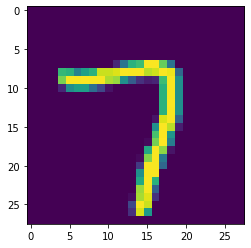

In [26]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Model & Optimization and Loss function

In [27]:
# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),1024),
        act,
        nn.Linear(1024,300),
        act,
        nn.Linear(300,10)
        )

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

## Train & Test

In [28]:
loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

Epoch: 1 \Loss: tensor(0.3980, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0303, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0172, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 26 \Loss: tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward>)
total 10000
correct tensor(9810., device='cuda:0')
accuracy tensor(0.9810, device='cuda:0')


# Plot result & Confusion matrix

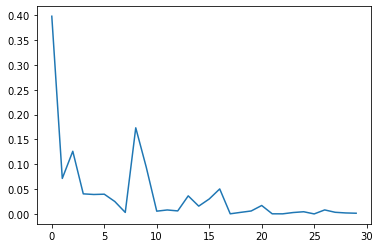

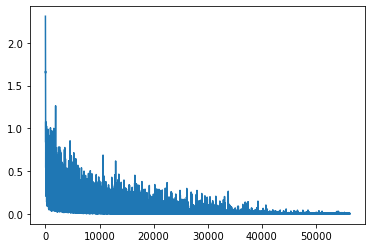

prediction : (10000,)
true label : (10000,)


array([[ 970,    0,    2,    2,    0,    2,    2,    1,    1,    0],
       [   0, 1123,    1,    3,    0,    1,    2,    1,    4,    0],
       [   5,    0, 1008,    5,    2,    0,    3,    3,    6,    0],
       [   0,    0,    4,  995,    0,    3,    0,    3,    3,    2],
       [   0,    0,    3,    1,  961,    1,    4,    3,    0,    9],
       [   2,    0,    0,    8,    1,  871,    3,    1,    4,    2],
       [   2,    1,    1,    1,    3,    3,  944,    0,    3,    0],
       [   2,    2,    7,    2,    0,    0,    0, 1008,    4,    3],
       [   3,    0,    3,    4,    3,    5,    2,    1,  949,    4],
       [   0,    2,    1,    4,    9,    4,    1,    4,    3,  981]])

In [29]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Build FC Layer Model
(Show inner distribution)

In [30]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)

        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [31]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.6025406718254089
5 epoch loss: 0.2432727962732315
10 epoch loss: 0.020025281235575676
15 epoch loss: 0.00405172910541296
20 epoch loss: 0.0036653371062129736
25 epoch loss: 0.00029865471879020333
total 10000
correct tensor(9830., device='cuda:0')
accuracy tensor(0.9830, device='cuda:0')


# Plot result

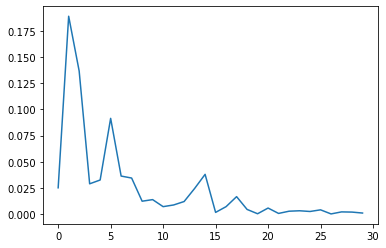

prediction : (10000,)
true label : (10000,)


array([[ 971,    0,    1,    1,    1,    1,    1,    1,    2,    1],
       [   0, 1126,    2,    2,    0,    1,    2,    1,    1,    0],
       [   5,    0, 1007,    6,    2,    0,    4,    4,    4,    0],
       [   1,    0,    4,  994,    1,    0,    0,    2,    4,    4],
       [   0,    1,    2,    1,  963,    1,    3,    2,    0,    9],
       [   4,    1,    0,    7,    1,  866,    5,    1,    4,    3],
       [   3,    1,    1,    0,    3,    3,  947,    0,    0,    0],
       [   1,    1,    9,    2,    1,    1,    0, 1006,    2,    5],
       [   2,    0,    4,    4,    3,    4,    2,    3,  950,    2],
       [   2,    3,    0,    5,   10,    1,    0,    5,    0,  983]])

In [36]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Show inner distribution

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


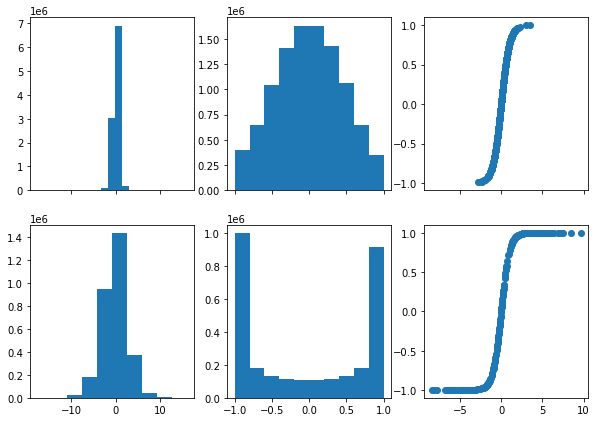

In [37]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

# Add Batch Normalize Layers

In [38]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)

        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [39]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.1568707674741745
5 epoch loss: 0.09403706341981888
10 epoch loss: 0.014135624282062054
15 epoch loss: 0.0011332990834489465
20 epoch loss: 0.0006058194558136165
25 epoch loss: 0.0023000261280685663
total 10000
correct tensor(9833., device='cuda:0')
accuracy tensor(0.9833, device='cuda:0')


## Plot the result

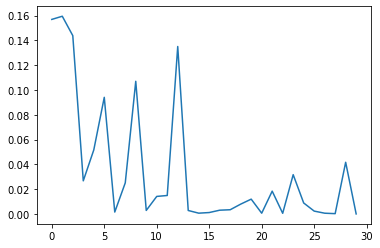

prediction : (10000,)
true label : (10000,)


array([[ 969,    1,    1,    0,    0,    1,    3,    3,    0,    2],
       [   1, 1126,    1,    2,    0,    0,    1,    1,    3,    0],
       [   1,    1, 1018,    2,    1,    0,    0,    5,    3,    1],
       [   0,    0,    3,  990,    0,    7,    0,    3,    2,    5],
       [   1,    0,    0,    0,  967,    0,    3,    2,    1,    8],
       [   2,    0,    0,    4,    1,  875,    4,    1,    3,    2],
       [   3,    2,    0,    1,    1,    7,  942,    0,    2,    0],
       [   0,    1,    7,    3,    0,    0,    0, 1013,    1,    3],
       [   2,    0,    3,    4,    3,    4,    1,    0,  953,    4],
       [   1,    3,    1,    4,   15,    1,    1,    2,    1,  980]])

In [40]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Show inner distribution

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


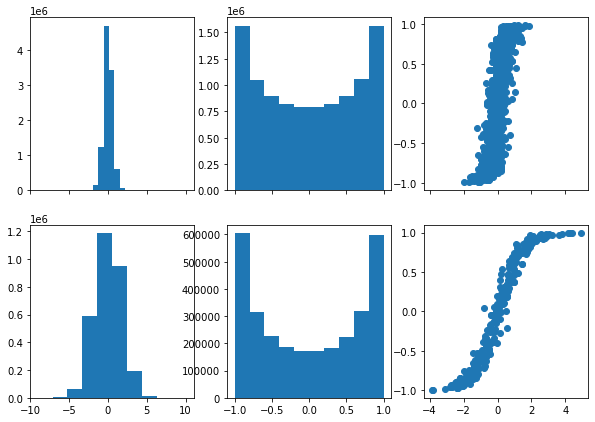

In [41]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()
    
plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

# Add Dropout Layers

In [42]:
# hyper parameter setting
learning_rate = 1e-1
epochs = 100
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 10
dropout_rate = .2 # probability to be 0 

In [43]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)
        drop1 = self.drop1(hidden1)
        
        output2 = self.fc2(drop1)
        hidden2 = self.act2(output2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [44]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.26992082595825195
10 epoch loss: 0.14887158572673798
20 epoch loss: 0.003663990879431367
30 epoch loss: 0.08490128070116043
40 epoch loss: 0.000489105936139822
50 epoch loss: 0.03175872191786766
60 epoch loss: 0.0014584503369405866
70 epoch loss: 0.00013634675997309387
80 epoch loss: 0.0021662318613380194
90 epoch loss: 0.00016941112698987126
total 10000
correct tensor(9831., device='cuda:0')
accuracy tensor(0.9831, device='cuda:0')


## Plot result

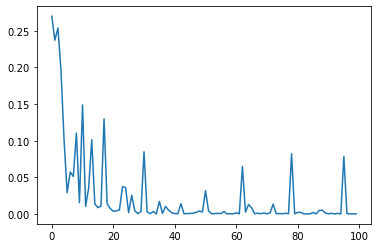

prediction : (10000,)
true label : (10000,)


array([[ 974,    1,    1,    0,    0,    0,    1,    1,    1,    1],
       [   0, 1127,    1,    2,    0,    1,    2,    1,    1,    0],
       [   5,    1, 1014,    2,    1,    0,    3,    2,    4,    0],
       [   0,    0,    3,  996,    0,    2,    0,    3,    2,    4],
       [   0,    1,    2,    1,  963,    0,    5,    2,    0,    8],
       [   3,    0,    0,    7,    1,  870,    4,    1,    3,    3],
       [   3,    2,    0,    0,    2,    4,  945,    0,    2,    0],
       [   1,    4,    6,    1,    0,    0,    0, 1013,    2,    1],
       [   3,    1,    2,    4,    4,    4,    0,    3,  950,    3],
       [   2,    3,    0,    4,    9,    3,    0,    8,    1,  979]])

In [45]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Add Batch norm, Dropout Layers

In [46]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        drop1 = self.drop1(hidden1)

        output2 = self.fc2(drop1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [47]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.26577964425086975
10 epoch loss: 0.02875658869743347
20 epoch loss: 0.00935269147157669
30 epoch loss: 0.0583798810839653
40 epoch loss: 6.5886095399037e-05
50 epoch loss: 0.0003207148693036288
60 epoch loss: 0.002164068864658475
70 epoch loss: 0.003487953683361411
80 epoch loss: 0.005182133987545967
90 epoch loss: 0.07606277614831924
total 10000
correct tensor(9857., device='cuda:0')
accuracy tensor(0.9857, device='cuda:0')


# Plot result

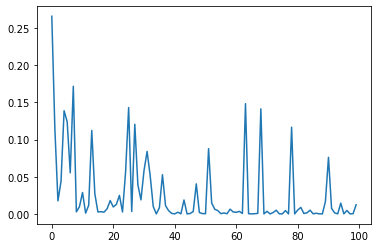

prediction : (10000,)
true label : (10000,)


array([[ 973,    1,    1,    0,    0,    1,    2,    1,    1,    0],
       [   0, 1128,    2,    1,    0,    0,    2,    1,    1,    0],
       [   5,    2, 1011,    2,    2,    0,    2,    3,    4,    1],
       [   0,    0,    4,  998,    0,    1,    0,    2,    3,    2],
       [   0,    0,    0,    1,  964,    0,    5,    0,    2,   10],
       [   2,    0,    0,    5,    0,  876,    4,    1,    3,    1],
       [   3,    2,    0,    0,    1,    4,  948,    0,    0,    0],
       [   2,    3,    7,    2,    1,    0,    0, 1008,    0,    5],
       [   3,    1,    1,    3,    2,    2,    0,    1,  959,    2],
       [   1,    2,    0,    5,    6,    1,    0,    2,    0,  992]])

In [49]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Advanced: batch norm + dropout in CNN

In [50]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# batchnorm + dropout in CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding =1), # 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding =1), # 14 x 14 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(100,10)
        )
    def forward(self, x):
        feature_extraction = self.feature_extraction(x)
        flatten = feature_extraction.view(batch_size, -1)         
        logit = self.classifier(flatten)
        
        return logit
        
model = CNN().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [51]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())
        
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

0 epoch loss: 0.015511471778154373
10 epoch loss: 0.021025337278842926
20 epoch loss: 0.00038350600516423583
30 epoch loss: 0.0011615512194111943
40 epoch loss: 0.0001576682843733579
50 epoch loss: 6.29682544968091e-05
60 epoch loss: 0.0010363548062741756
70 epoch loss: 2.6411930775793735e-06
80 epoch loss: 1.643268478801474e-05
90 epoch loss: 1.6763650592110935e-06
Accuracy of the model: 0.9936898946762085
